# Question 3

## (a)

K-fold cross validation is implemented by:

1) Dividing dataset into k groups of len n/k.

2) Save the first fold as the validation set. 

3) Compute the MSE for all other folds, leaving out df[k], the validation set

4) Calculate the mean of all MSEs to get an estimate of the k-fold CV.

## (b)

i. Validation Set

K-fold CV has less variance as it's estimate is generated over k folds. Validation sets are a simple and lightweight computation. It is only trained once but it leaves room for high variance as a training set is not being utilized. This affects small datasets. The bias is also strong if the validation set does not properly represent the overall dataset.

ii. LOOCV

K-fold CV has better computational performance than LOOCV as n increases. The bias-variance trade off also helps propogate off variance and introducing bias as the validation set is left out. LOOCV works best on small datasets as it is more flexible and can be more precise. 

# Question 6

## (a)

In [84]:
import pandas as pd
import statsmodels.api as sm 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

default = pd.read_csv('Default.csv')
default['default'] = default['default'].map({'Yes': 1, 'No': 0})
 
X = default[['income', 'balance']]
y = default['default']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
 
model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
 
y_pred_prob = model.predict(X_test)
 
# Converting to y/n 
y_pred = (y_pred_prob >= 0.5).astype(int)

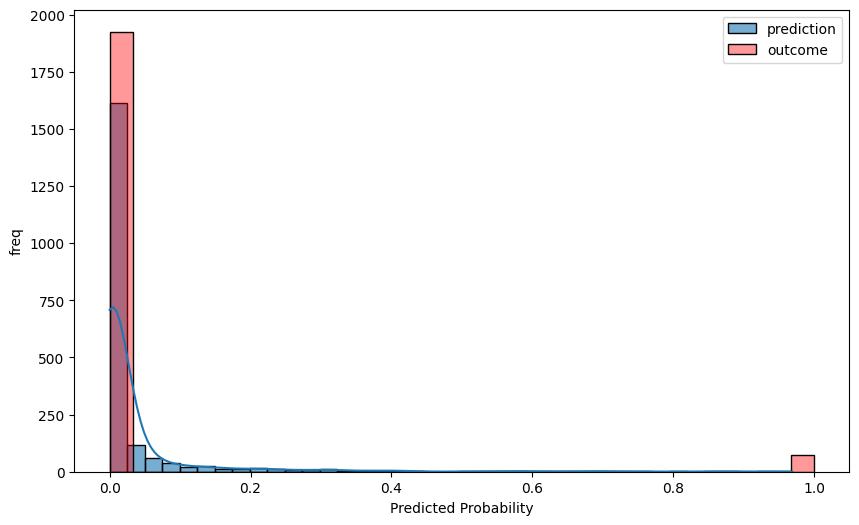

In [94]:
plt.figure(figsize=(10,6))
sns.histplot(y_pred_prob, bins=39, kde=True, alpha=0.6, label='prediction')
sns.histplot(y_test, bins=30, kde=False, color='red', alpha=0.4, label='outcome')
plt.xlabel('Predicted Probability')
plt.ylabel('freq')
plt.legend()
plt.show()

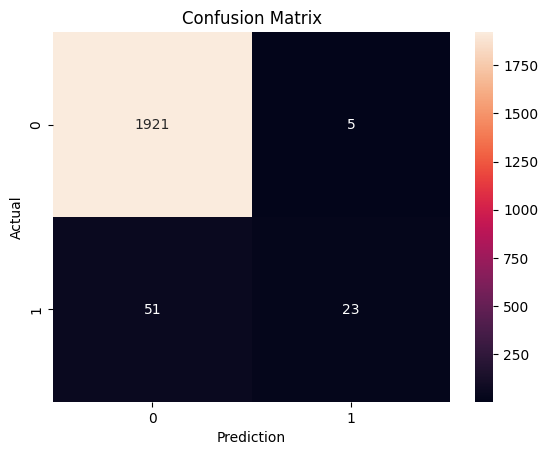

In [89]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

$Pr(0) accuracy: 97.4%$

$Pr(1) accuracy: 82.1%$

$Pr(0) inaccuracy: 2.6%$

$Pr(1) inaccuracy: 17.9%$

$Overall Accuracy: 97.2%$

In [65]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                default   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -623.83
Date:                Fri, 11 Oct 2024   Deviance:                       1247.7
Time:                        11:33:04   Pearson chi2:                 3.80e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1218
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.2316      0.477    -23.543      0.000     -12.167     -10.297
income      1.558e-05    5.6e-06      2.783      0.005    4.61e-06    2.66e-05
balance        0.0055      0.000     22.133      0.000       0.005       0.006
==============================================================================
"""

$Y=-11.23+1.56*10^{-5}income+0.0056balance$

## (b)

In [74]:
''' 
    Fits a logistic regression model to the Default dataset
    using the specified index and returns the coefficient estimates
    for income and balance.
    
    Parameters:
    - data:<DataFrame>
    - index:<List> Of indices for resampling the dataset
    
    Return:
        [coef.income, coef.balance]
''' 
def boot_fn(data, index):

    resampled_data = data.iloc[index]

    X = resampled_data[['income', 'balance']]
    y = resampled_data['default']

    X = sm.add_constant(X)

    model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

    return model.params[['income', 'balance']]

## (c)

In [78]:
from functools import partial 
np.random.seed(1)
index = np.random.choice(a=len(default), size=len(default), replace=True)

rng = np.random.default_rng(0)
partial = partial(boot_fn, default)

res = np.array([partial(rng.choice(len(default), len(default), replace=True))
                 for _ in range(10)])
stderr = np.std(res, axis=0)
print(f'STD Income: {stderr[0]} \nSTD Balance: {stderr[1]}')
# boot_fn(default, index)

STD Income: 5.555094577549571e-06 
STD Balance: 0.00023526954529095226


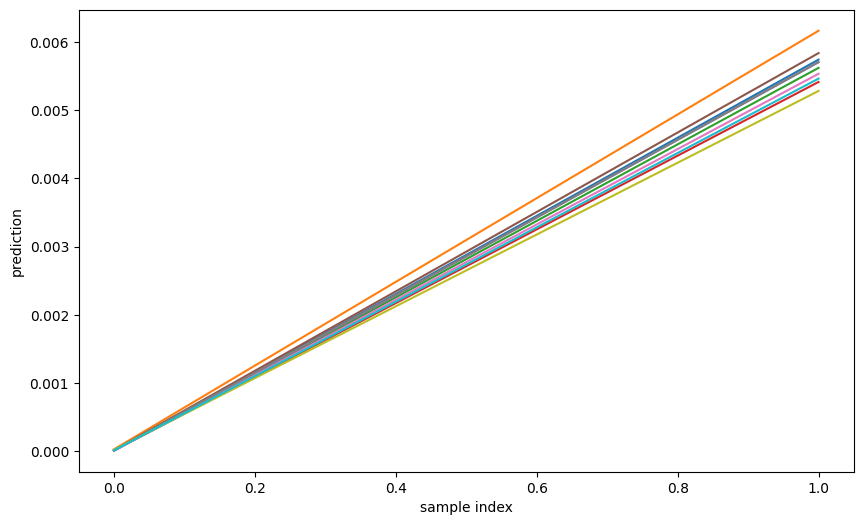

In [79]:
plt.figure(figsize=(10,6))
for i, res in enumerate(res): 
    plt.plot(res, label=f'Sample {i+1}')

plt.xlabel('sample index')
plt.ylabel('prediction')
plt.show()

# (d)

Standard Errors

Bootstrapping: 
    - Income: 5.56e-06
    - Balance: 2.35e-04

Logistic Regression Model:
    - Income: 5.6e-06
    - Balance: 0

The standard error of income is the same for both methods. For balance, the regression model has an error of zero. This means one of two things:
    1. The predictor can 100% accurately predict the output without error
    2. The predictor is redundant and can be represented within another predictor

# Question 7

## (a)

In [95]:
Weekly = pd.read_csv('Weekly.csv')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [124]:
from sklearn.linear_model import LogisticRegression

X = Weekly[['Lag1', 'Lag2']]
y = Weekly['Direction'].map({ 'Up': 1, 'Down': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
 
model = sm.GLM(y_train, X_train, family=sm.families.Binomial()).fit()
 
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

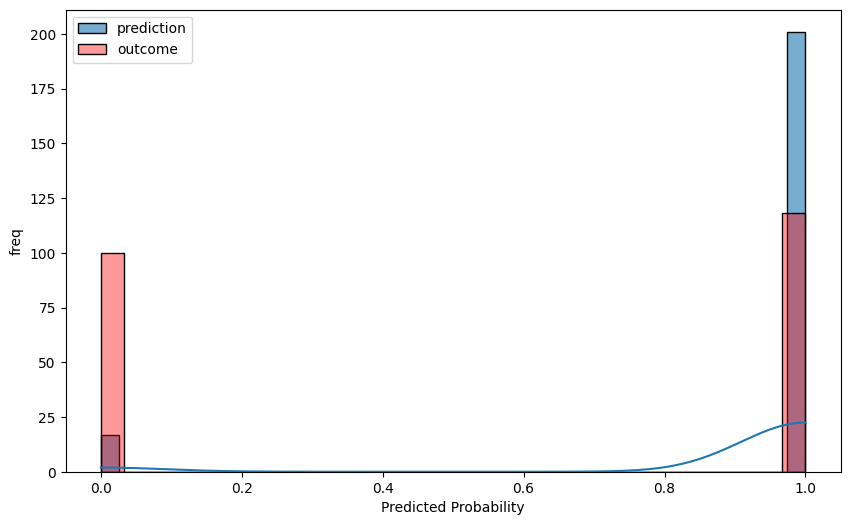

In [126]:
plt.figure(figsize=(10,6))
sns.histplot(y_pred, bins=39, kde=True, alpha=0.6, label='prediction')
sns.histplot(y_test, bins=30, kde=False, color='red', alpha=0.4, label='outcome')
plt.xlabel('Predicted Probability')
plt.ylabel('freq')
plt.legend()
plt.show()

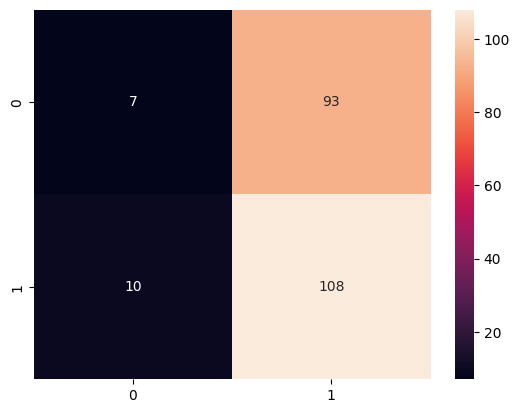

In [127]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d')
plt.show()

In [120]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
print(len(y_test))
print(len(y_pred_prob))

218
871
871
218
218
